# Quick Debug: TSC Algorithms on Pedestrian Dataset

Simple sanity check for all tsckit algorithms:
- **Dataset**: Pedestrian (1% train, 1% test for speed)
- **Algorithms**: All 10 algorithms including both ensembles
- **Purpose**: Verify everything works after code changes

In [1]:
import sys

sys.path.extend([
    '/Users/urav/code/research',                    # For tsckit package
    '/Users/urav/code/research/quant/code',         # For original quant.py
    '/Users/urav/code/research/hydra/code',         # For original hydra.py  
    '/Users/urav/code/research/aaltd2024/code',     # For quant_aaltd.py, hydra_gpu.py, utils.py, ridge.py
])

In [2]:
from tsckit import Experiment, MonsterDataset

from tsckit.algorithms import (
    AeonAlgorithm, HydraAALTD2024, HydraOriginal, QuantAALTD2024, QuantOriginal,
    HydraQuantStackedAALTD2024, # Old ensemble (data leakage)
    HydraQuantStacked           # New clean ensemble (proper CV)
)

/Users/urav/code/research/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Create dataset and experiment
dataset = MonsterDataset("Pedestrian", fold=0, train_pct=1, test_pct=1)
print("Dataset info:")
print(dataset.info())

Dataset info:
Pedestrian (fold 0):
  Shape: 1 channels x 24 time points
  Classes: 82
  Total samples: 189621
  Train samples: 1516 (1%)
  Test samples: 379 (1%)


In [4]:
# Add all algorithms to experiment
algorithms = [
    # Original implementations
    QuantOriginal(depth=6),
    HydraOriginal(k=4, g=16, seed=42),
    
    # AALTD2024 implementations
    QuantAALTD2024(num_estimators=50),  # Reduced for speed
    HydraAALTD2024(k=4, g=16, seed=42),
    
    # AEON implementations
    AeonAlgorithm(algorithm="quant"),
    AeonAlgorithm(algorithm="hydra", n_kernels=4, n_groups=16),
    AeonAlgorithm(algorithm="rocket", n_kernels=500),
    AeonAlgorithm(algorithm="multirocket", n_kernels=100, max_dilations_per_kernel=16),
    
    # Ensembles
    HydraQuantStackedAALTD2024(hydra_k=4, hydra_g=16, hydra_seed=42, quant_estimators=50),  # Old (data leakage)
    HydraQuantStacked(n_folds=3, hydra_k=4, hydra_g=16, hydra_seed=42, n_estimators=50),    # New (clean CV)
]

In [5]:
# Add dataset and algorithms to experiment
exp = Experiment("debug_pedestrian")
exp.add_dataset(dataset)
for algo in algorithms:
    exp.add_algorithm(algo)

print(f"🔬 Experiment setup complete: {len(algorithms)} algorithms")

🔬 Experiment setup complete: 10 algorithms


In [6]:
# Run all experiments
exp.run(verbose=True)

🔬 Experiment: debug_pedestrian
📊 1 datasets × 10 algorithms = 10 runs
💾 Results will not be saved (no output_dir specified)


Pedestrian + HydraQuantStacked(folds=3,k=4,g=16,est=50):  90%|█████████ | 9/10 [00:03<00:00,  2.94it/s, acc=0.515]                /Users/urav/code/research/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
Pedestrian + HydraQuantStacked(folds=3,k=4,g=16,est=50): 100%|██████████| 10/10 [00:03<00:00,  2.67it/s, acc=0.504]


In [7]:
# Quick summary
print(exp.summary())

📋 Experiment: debug_pedestrian
✅ 10 successful / 10 total runs

🏆 Top 3 Results (by accuracy):
   1. QuantOriginal(depth=6, div=4) on Pedestrian: 0.5435
   2. AeonQuant() on Pedestrian: 0.5383
   3. HydraQuantStacked(hydra_k=4,hydra_g=16,quant_est=50) on Pedestrian: 0.5145

⏱️  Average runtime: 0.37s


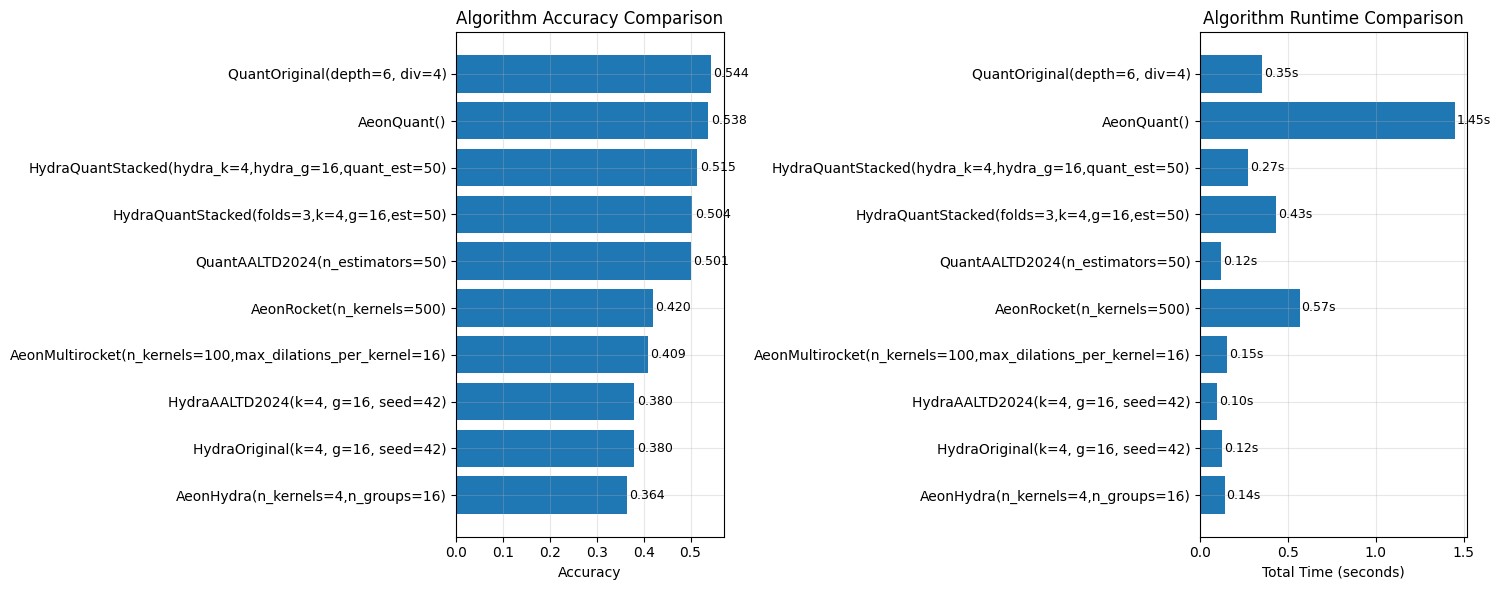


📊 Key Results:
🔄 Old Ensemble (data leakage):   0.5145
✨ New Ensemble (clean CV):      0.5040
📈 Improvement: -0.0106

🏆 Best Algorithm: QuantOriginal(depth=6, div=4) (0.5435)
⚡ Fastest Algorithm: HydraAALTD2024(k=4, g=16, seed=42) (0.096s)


In [8]:
# Detailed results analysis
import matplotlib.pyplot as plt

df = exp.results_df()
successful = df[df['status'] == 'success'].copy()

if len(successful) > 0:
    # Sort by accuracy for better visualization
    successful = successful.sort_values('accuracy', ascending=True)
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Accuracy comparison
    ax1.barh(range(len(successful)), successful['accuracy'])
    ax1.set_yticks(range(len(successful)))
    ax1.set_yticklabels(successful['algorithm_name'], fontsize=10)
    ax1.set_xlabel('Accuracy')
    ax1.set_title('Algorithm Accuracy Comparison')
    ax1.grid(True, alpha=0.3)
    
    # Add accuracy values as text
    for i, v in enumerate(successful['accuracy']):
        ax1.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)
    
    # Runtime comparison
    ax2.barh(range(len(successful)), successful['total_time'])
    ax2.set_yticks(range(len(successful)))
    ax2.set_yticklabels(successful['algorithm_name'], fontsize=10)
    ax2.set_xlabel('Total Time (seconds)')
    ax2.set_title('Algorithm Runtime Comparison')
    ax2.grid(True, alpha=0.3)
    
    # Add time values as text
    for i, v in enumerate(successful['total_time']):
        ax2.text(v + 0.01, i, f'{v:.2f}s', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Ensemble comparison table
    print("\n📊 Key Results:")
    print("=" * 60)
    
    # Find ensemble results
    old_ensemble = successful[successful['algorithm_name'].str.contains('HydraQuantStacked\\(hydra_k')]
    new_ensemble = successful[successful['algorithm_name'].str.contains('HydraQuantStacked\\(folds')]
    
    if len(old_ensemble) > 0 and len(new_ensemble) > 0:
        print(f"🔄 Old Ensemble (data leakage):   {old_ensemble.iloc[0]['accuracy']:.4f}")
        print(f"✨ New Ensemble (clean CV):      {new_ensemble.iloc[0]['accuracy']:.4f}")
        improvement = new_ensemble.iloc[0]['accuracy'] - old_ensemble.iloc[0]['accuracy']
        print(f"📈 Improvement: {improvement:+.4f}")
    
    print(f"\n🏆 Best Algorithm: {successful.iloc[-1]['algorithm_name']} ({successful.iloc[-1]['accuracy']:.4f})")
    print(f"⚡ Fastest Algorithm: {successful.loc[successful['total_time'].idxmin(), 'algorithm_name']} ({successful['total_time'].min():.3f}s)")
else:
    print("❌ No successful runs to analyze")

# Show any failures
failed = df[df['status'] == 'failed']
if len(failed) > 0:
    print(f"\n⚠️  {len(failed)} algorithms failed:")
    for _, row in failed.iterrows():
        print(f"   - {row['algorithm_name']}: {row['error']}")

In [ ]:
print("✅ Debug completed succesxwsfully!")
print("💡 Note: Results not saved (debug mode). Use output_dir for persistent storage.")

✅ Debug completed successfully!
💡 Note: Results not saved (debug mode). Use output_dir for persistent storage.
